# Evergreen Backtest Playground (v1 / v2 / v3 / v4 / v5)
Python 엔진(`v1.py`~`v5.py`) 검증 및 업비트 실데이터 실행용 노트북


In [160]:
from __future__ import annotations

from datetime import datetime, timedelta, timezone
from pathlib import Path
import math
import sys

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm


In [161]:
def find_repo_root(start: Path) -> Path:
    current = start.resolve()
    for candidate in [current, *current.parents]:
        if (candidate / 'pyproject.toml').exists():
            return candidate
    raise RuntimeError('Cannot find repository root (pyproject.toml)')

REPO_ROOT = find_repo_root(Path.cwd())
PY_DIR = REPO_ROOT / 'src' / 'test' / 'python'
if str(PY_DIR) not in sys.path:
    sys.path.insert(0, str(PY_DIR))

print('REPO_ROOT =', REPO_ROOT)
print('PY_DIR    =', PY_DIR)

REPO_ROOT = C:\Users\phant\IdeaProjects\evergreen
PY_DIR    = C:\Users\phant\IdeaProjects\evergreen\src\test\python


In [162]:
from v1 import (
    BacktestConfigV1,
    BacktestServiceV1,
    CandleBar as CandleBarV1,
    GridSearchServiceV1,
)
from v2 import (
    BacktestConfigV2,
    BacktestServiceV2,
    CandleBar as CandleBarV2,
    GridSearchServiceV2,
    UpbitDataServiceV2,
)
from v3 import (
    BacktestConfigV3,
    BacktestServiceV3,
    CandleBar as CandleBarV3,
    GridSearchServiceV3,
)
from v4 import (
    BacktestConfigV4,
    BacktestServiceV4,
    CandleBar as CandleBarV4,
    GridSearchServiceV4,
)
from v5 import (
    BacktestConfigV5,
    BacktestServiceV5,
    CandleBar as CandleBarV5,
    GridSearchServiceV5,
)


## 1) Synthetic Data Helper

In [163]:
def synthetic_rows(n: int = 420):
    start = datetime(2023, 1, 1, tzinfo=timezone.utc)
    rows = []
    price = 100.0
    for i in range(n):
        wave = math.sin(i / 14.0) * 2.0
        drift = 0.18 if i < n * 0.55 else -0.10
        shock = 0.0 if i % 41 else -3.5
        open_price = price
        close_price = max(1.0, price + wave + drift + shock)
        high = max(open_price, close_price) + 0.8
        low = min(open_price, close_price) - 0.8
        volume = 1200.0 + i
        rows.append((start + timedelta(days=i), open_price, high, low, close_price, volume))
        price = close_price
    return rows

## 2) Real Upbit Data (NEW)
아래 셀을 실행하면 업비트 일봉 데이터를 API+로컬 캐시로 가져옵니다.

In [164]:
USE_REAL_DATA = True
MARKET = 'KRW-BTC'
FROM_DT = datetime(1000, 1, 1, tzinfo=timezone.utc)
TO_DT = datetime.now(timezone.utc)
CACHE_DIR = REPO_ROOT / 'outputs' / 'data' / 'upbit-cache'

In [165]:
real_cfg = BacktestConfigV2(
    market=MARKET,
    from_dt=FROM_DT,
    to_dt=TO_DT,
    csv_cache_dir=str(CACHE_DIR),
)

upbit = UpbitDataServiceV2()
real_bars = upbit.load_bars(real_cfg)

print('loaded real bars =', len(real_bars))
print('first =', real_bars[0].timestamp if real_bars else None)
print('last  =', real_bars[-1].timestamp if real_bars else None)
print('cache dir =', CACHE_DIR)

loaded real bars = 3071
first = 2017-09-25 00:00:00+00:00
last  = 2026-02-20 00:00:00+00:00
cache dir = C:\Users\phant\IdeaProjects\evergreen\outputs\data\upbit-cache


In [166]:
# 실데이터 샘플 확인
real_bars[:3], real_bars[-3:]

([CandleBar(timestamp=datetime.datetime(2017, 9, 25, 0, 0, tzinfo=datetime.timezone.utc), open=4201000.0, high=4333000.0, low=4175000.0, close=4322000.0, volume=132.48475499),
  CandleBar(timestamp=datetime.datetime(2017, 9, 26, 0, 0, tzinfo=datetime.timezone.utc), open=4317000.0, high=4418000.0, low=4311000.0, close=4321000.0, volume=22.78833969),
  CandleBar(timestamp=datetime.datetime(2017, 9, 27, 0, 0, tzinfo=datetime.timezone.utc), open=4322000.0, high=4677000.0, low=4318000.0, close=4657000.0, volume=32.2696617)],
 [CandleBar(timestamp=datetime.datetime(2026, 2, 18, 0, 0, tzinfo=datetime.timezone.utc), open=100054000.0, high=100956000.0, low=98115000.0, close=98622000.0, volume=1554.46249904),
  CandleBar(timestamp=datetime.datetime(2026, 2, 19, 0, 0, tzinfo=datetime.timezone.utc), open=98622000.0, high=99409000.0, low=97069000.0, close=98846000.0, volume=1533.36606451),
  CandleBar(timestamp=datetime.datetime(2026, 2, 20, 0, 0, tzinfo=datetime.timezone.utc), open=98847000.0, hig

## 3) Choose Input Rows

In [167]:
if USE_REAL_DATA:
    base_rows = [(b.timestamp, b.open, b.high, b.low, b.close, b.volume) for b in real_bars]
else:
    base_rows = synthetic_rows()

bars_v1 = [CandleBarV1(*row) for row in base_rows]
bars_v2 = [CandleBarV2(*row) for row in base_rows]
bars_v3 = [CandleBarV3(*row) for row in base_rows]
bars_v4 = [CandleBarV4(*row) for row in base_rows]
bars_v5 = [CandleBarV5(*row) for row in base_rows]
print('bars =', len(base_rows), 'source =', 'real' if USE_REAL_DATA else 'synthetic')


bars = 3071 source = real


## 4) Grid Search and Backtest

In [168]:
split_ratio = 0.7
split_index = max(2, min(len(base_rows) - 2, int(len(base_rows) * split_ratio)))
val_v1, test_v1 = bars_v1[:split_index], bars_v1[split_index:]
val_v2, test_v2 = bars_v2[:split_index], bars_v2[split_index:]
val_v3, test_v3 = bars_v3[:split_index], bars_v3[split_index:]
val_v4, test_v4 = bars_v4[:split_index], bars_v4[split_index:]
val_v5, test_v5 = bars_v5[:split_index], bars_v5[split_index:]
print('validation rows =', len(val_v1), '| test rows =', len(test_v1))


validation rows = 2149 | test rows = 922


In [169]:
cfg_v1 = BacktestConfigV1(
    top_k=5,
    grid_rsi_range='20:45:5',
    grid_ma_len_range='20:120:10',
    grid_ma_slope_range='1:9:2',
)
svc_v1 = BacktestServiceV1()
gs_v1 = GridSearchServiceV1(svc_v1)
cand_v1 = gs_v1.search(val_v1, cfg_v1)
best_v1 = cand_v1[0]
res_v1_val = svc_v1.backtest_daily_strategy(val_v1, best_v1.params)
res_v1_test = svc_v1.backtest_daily_strategy(test_v1, best_v1.params)
best_v1

GridSearchRowV1(params=StrategyParamsV1(fee_per_side=0.0005, slippage=0.0002, rsi_buy=45.0, ma_len=120, ma_slope_days=7), calmar_like=1.1825251406220452, cagr=0.37816161535816795, mdd=-0.3197916072712358, final_equity=6.594938302149976)

In [170]:
cfg_v2 = BacktestConfigV2(
    top_k=5,
    grid_parallelism=1,
    grid_ma_len_range='80:200:40',
    grid_atr_period_range='10:18:4',
    grid_atr_trail_mult_range='2:4:1',
    grid_regime_band_range='0.01:0.03:0.01',
)
svc_v2 = BacktestServiceV2()
gs_v2 = GridSearchServiceV2(svc_v2)
cand_v2 = gs_v2.search(val_v2, cfg_v2)
best_v2 = cand_v2[0]
res_v2_val = svc_v2.backtest_daily_strategy(val_v2, best_v2.params)
res_v2_test = svc_v2.backtest_daily_strategy(test_v2, best_v2.params)
res_v2_full = svc_v2.backtest_daily_strategy(bars_v2, best_v2.params)
best_v2

GridSearchRowV2(params=StrategyParamsV2(fee_per_side=0.0005, slippage=0.0002, regime_ema_len=120, atr_period=14, atr_trail_multiplier=3.0, regime_band=0.01), calmar_like=1.4487923782957604, cagr=0.5234879976701492, mdd=-0.3613271339030215, final_equity=11.892104904860492)

In [171]:
cfg_v3 = BacktestConfigV3(
    top_k=5,
    grid_parallelism=1,
    grid_ma_len_range='80:200:40',
    grid_atr_period_range='10:18:4',
    grid_atr_trail_mult_range='2:4:1',
    grid_regime_band_range='0.01:0.03:0.01',
    grid_vol_target_range='0.01:0.03:0.01',
    grid_max_leverage_range='1.0:2.0:0.5',
    grid_min_exposure_range='0:0:1',
)
svc_v3 = BacktestServiceV3()
gs_v3 = GridSearchServiceV3(svc_v3)
cand_v3 = gs_v3.search(val_v3, cfg_v3)
best_v3 = cand_v3[0]
res_v3_val = svc_v3.backtest_daily_strategy(val_v3, best_v3.params)
res_v3_test = svc_v3.backtest_daily_strategy(test_v3, best_v3.params)
res_v3_full = svc_v3.backtest_daily_strategy(bars_v3, best_v3.params)
best_v3


GridSearchRowV3(params=StrategyParamsV3(fee_per_side=0.0005, slippage=0.0002, regime_ema_len=120, atr_period=18, atr_trail_multiplier=2.0, regime_band=0.01, vol_target=0.03, max_leverage=2.0, min_exposure=0.0), calmar_like=1.9479445152800146, cagr=0.4215847367253549, mdd=-0.21642543379360712, final_equity=7.914833984625232)

In [172]:
cfg_v4 = BacktestConfigV4(
    top_k=5,
    grid_parallelism=1,
    grid_ma_len_range='80:200:40',
    grid_atr_period_range='10:18:4',
    grid_atr_trail_mult_range='2:4:1',
    grid_regime_band_range='0.01:0.03:0.01',
    grid_weekly_ema_len_range='10:30:10',
)
svc_v4 = BacktestServiceV4()
gs_v4 = GridSearchServiceV4(svc_v4)
cand_v4 = gs_v4.search(val_v4, cfg_v4)
best_v4 = cand_v4[0]
res_v4_val = svc_v4.backtest_daily_strategy(val_v4, best_v4.params)
res_v4_test = svc_v4.backtest_daily_strategy(test_v4, best_v4.params)
res_v4_full = svc_v4.backtest_daily_strategy(bars_v4, best_v4.params)
best_v4


GridSearchRowV4(params=StrategyParamsV4(fee_per_side=0.0005, slippage=0.0002, regime_ema_len=120, atr_period=14, atr_trail_multiplier=2.0, regime_band=0.01, weekly_ema_len=20), calmar_like=2.5032360587827163, cagr=0.47363396523066825, mdd=-0.18920866994101582, final_equity=9.77874499265697)

In [173]:
cfg_v5 = BacktestConfigV5(
    top_k=5,
    grid_parallelism=1,
    grid_ma_len_range='80:200:40',
    grid_atr_period_range='10:18:4',
    grid_atr_mult_low_vol_range='1.5:2.5:0.5',
    grid_atr_mult_high_vol_range='3.0:4.0:0.5',
    grid_vol_regime_lookback_range='20:40:10',
    grid_vol_regime_threshold_range='0.6:0.8:0.1',
    grid_regime_band_range='0.01:0.03:0.01',
)
svc_v5 = BacktestServiceV5()
gs_v5 = GridSearchServiceV5(svc_v5)
cand_v5 = gs_v5.search(val_v5, cfg_v5)
best_v5 = cand_v5[0]
res_v5_val = svc_v5.backtest_daily_strategy(val_v5, best_v5.params)
res_v5_test = svc_v5.backtest_daily_strategy(test_v5, best_v5.params)
res_v5_full = svc_v5.backtest_daily_strategy(bars_v5, best_v5.params)
best_v5


GridSearchRowV5(params=StrategyParamsV5(fee_per_side=0.0005, slippage=0.0002, regime_ema_len=120, atr_period=18, atr_mult_low_vol=2.0, atr_mult_high_vol=3.0, vol_regime_lookback=40, vol_regime_threshold=0.6, regime_band=0.01), calmar_like=1.8011735972114702, cagr=0.5709124352266033, mdd=-0.31696691318953096, final_equity=14.24133982128456)

In [174]:
def fmt_pct(x):
    return f"{x * 100:.2f}%"

def fmt_num(x):
    return f"{x:.4f}"

summary_rows = [
    ('v1_valid', res_v1_val.summary), ('v1_test', res_v1_test.summary),
    ('v2_valid', res_v2_val.summary), ('v2_test', res_v2_test.summary), ('v2_full', res_v2_full.summary),
    ('v3_valid', res_v3_val.summary), ('v3_test', res_v3_test.summary), ('v3_full', res_v3_full.summary),
    ('v4_valid', res_v4_val.summary), ('v4_test', res_v4_test.summary), ('v4_full', res_v4_full.summary),
    ('v5_valid', res_v5_val.summary), ('v5_test', res_v5_test.summary), ('v5_full', res_v5_full.summary),
]

summary_table = [
    {
        'run': name,
        'final_equity': fmt_num(s.final_equity),
        'final_equity_bh': fmt_num(s.final_equity_bh),
        'cagr': fmt_pct(s.cagr),
        'mdd': fmt_pct(s.mdd),
        'trades': s.trades,
        'range': s.range,
    }
    for name, s in summary_rows
]

pd.DataFrame(summary_table)


,run,final_equity,final_equity_bh,cagr,mdd,trades,range
0,v1_valid,6.5949,9.0932,37.82%,-31.98%,13,2017-09-25 00:00:00+00:00 -> 2023-08-13 00:00:...
1,v1_test,1.6490,2.5142,21.94%,-20.19%,8,2023-08-14 00:00:00+00:00 -> 2026-02-20 00:00:...
2,v2_valid,11.8921,9.0932,52.35%,-36.13%,38,2017-09-25 00:00:00+00:00 -> 2023-08-13 00:00:...
3,v2_test,1.4677,2.5142,16.44%,-19.08%,12,2023-08-14 00:00:00+00:00 -> 2026-02-20 00:00:...
4,v2_full,25.2250,22.8811,46.82%,-36.13%,52,2017-09-25 00:00:00+00:00 -> 2026-02-20 00:00:...
5,v3_valid,7.9148,9.0932,42.16%,-21.64%,639,2017-09-25 00:00:00+00:00 -> 2023-08-13 00:00:...
6,v3_test,1.6544,2.5142,22.10%,-22.70%,339,2023-08-14 00:00:00+00:00 -> 2026-02-20 00:00:...
7,v3_full,29.2853,22.8811,49.45%,-28.49%,1251,2017-09-25 00:00:00+00:00 -> 2026-02-20 00:00:...
8,v4_valid,9.7787,9.0932,47.36%,-18.92%,30,2017-09-25 00:00:00+00:00 -> 2023-08-13 00:00:...
9,v4_test,1.0006,2.5142,0.02%,-14.50%,12,2023-08-14 00:00:00+00:00 -> 2026-02-20 00:00:...


## 5) Additional Validation (Walk-forward, v1~v5)


In [175]:
WF_SPLITS = 3  # 늘리면 검증 강도↑, 실행시간↑
MIN_TRAIN_BARS = 300

def pct(x):
    return f"{x * 100:.2f}%"

def run_walkforward(name, bars, cfg, svc, gs):
    n = len(bars)
    segment = max(50, n // (WF_SPLITS + 1))
    rows = []
    for i in tqdm(range(WF_SPLITS), desc=f"{name} split", leave=False):
        train_end = segment * (i + 1)
        test_start = train_end
        test_end = min(n, train_end + segment)
        if train_end < MIN_TRAIN_BARS or (test_end - test_start) < 30:
            continue

        train_bars = bars[:train_end]
        test_bars = bars[test_start:test_end]

        cand = gs.search(train_bars, cfg)
        best = cand[0]
        test_res = svc.backtest_daily_strategy(test_bars, best.params)

        rows.append({
            'version': name,
            'split': i + 1,
            'train_range': f"{train_bars[0].timestamp.date()}~{train_bars[-1].timestamp.date()}",
            'test_range': f"{test_bars[0].timestamp.date()}~{test_bars[-1].timestamp.date()}",
            'cagr': pct(test_res.summary.cagr),
            'mdd': pct(test_res.summary.mdd),
            'final_equity': f"{test_res.summary.final_equity:.4f}",
            'final_bh': f"{test_res.summary.final_equity_bh:.4f}",
            'trades': test_res.summary.trades,
            'best_params': str(best.params),
        })
    return rows

wf_specs = [
    ('v1', bars_v1, cfg_v1, svc_v1, gs_v1),
    ('v2', bars_v2, cfg_v2, svc_v2, gs_v2),
    ('v3', bars_v3, cfg_v3, svc_v3, gs_v3),
    ('v4', bars_v4, cfg_v4, svc_v4, gs_v4),
    ('v5', bars_v5, cfg_v5, svc_v5, gs_v5),
]

wf_rows = []
for name, bars, cfg, svc, gs in tqdm(wf_specs, desc='walk-forward versions'):
    wf_rows += run_walkforward(name, bars, cfg, svc, gs)

pd.DataFrame(wf_rows)



walk-forward versions: 100%|██████████| 5/5 [01:29<00:00, 17.83s/it]


,version,split,train_range,test_range,cagr,mdd,final_equity,final_bh,trades,best_params
0,v1,1,2017-09-25~2019-10-31,2019-11-01~2021-12-06,1.07%,-23.67%,1.0226,5.7227,6,"StrategyParamsV1(fee_per_side=0.0005, slippage..."
1,v1,2,2017-09-25~2021-12-06,2021-12-07~2024-01-12,4.51%,-18.48%,1.0969,1.0049,4,"StrategyParamsV1(fee_per_side=0.0005, slippage..."
2,v1,3,2017-09-25~2024-01-12,2024-01-13~2026-02-17,0.32%,-18.70%,1.0068,1.7276,8,"StrategyParamsV1(fee_per_side=0.0005, slippage..."
3,v2,1,2017-09-25~2019-10-31,2019-11-01~2021-12-06,4.86%,-11.63%,1.1047,5.7227,4,"StrategyParamsV2(fee_per_side=0.0005, slippage..."
4,v2,2,2017-09-25~2021-12-06,2021-12-07~2024-01-12,28.51%,-21.61%,1.6923,1.0049,9,"StrategyParamsV2(fee_per_side=0.0005, slippage..."
5,v2,3,2017-09-25~2024-01-12,2024-01-13~2026-02-17,20.08%,-19.08%,1.4677,1.7276,12,"StrategyParamsV2(fee_per_side=0.0005, slippage..."
6,v3,1,2017-09-25~2019-10-31,2019-11-01~2021-12-06,6.75%,-19.58%,1.1469,5.7227,130,"StrategyParamsV3(fee_per_side=0.0005, slippage..."
7,v3,2,2017-09-25~2021-12-06,2021-12-07~2024-01-12,33.62%,-26.06%,1.8364,1.0049,329,"StrategyParamsV3(fee_per_side=0.0005, slippage..."
8,v3,3,2017-09-25~2024-01-12,2024-01-13~2026-02-17,32.17%,-22.70%,1.7950,1.7276,260,"StrategyParamsV3(fee_per_side=0.0005, slippage..."
9,v4,1,2017-09-25~2019-10-31,2019-11-01~2021-12-06,84.54%,-31.70%,3.6146,5.7227,10,"StrategyParamsV4(fee_per_side=0.0005, slippage..."


## 6) Plot Check


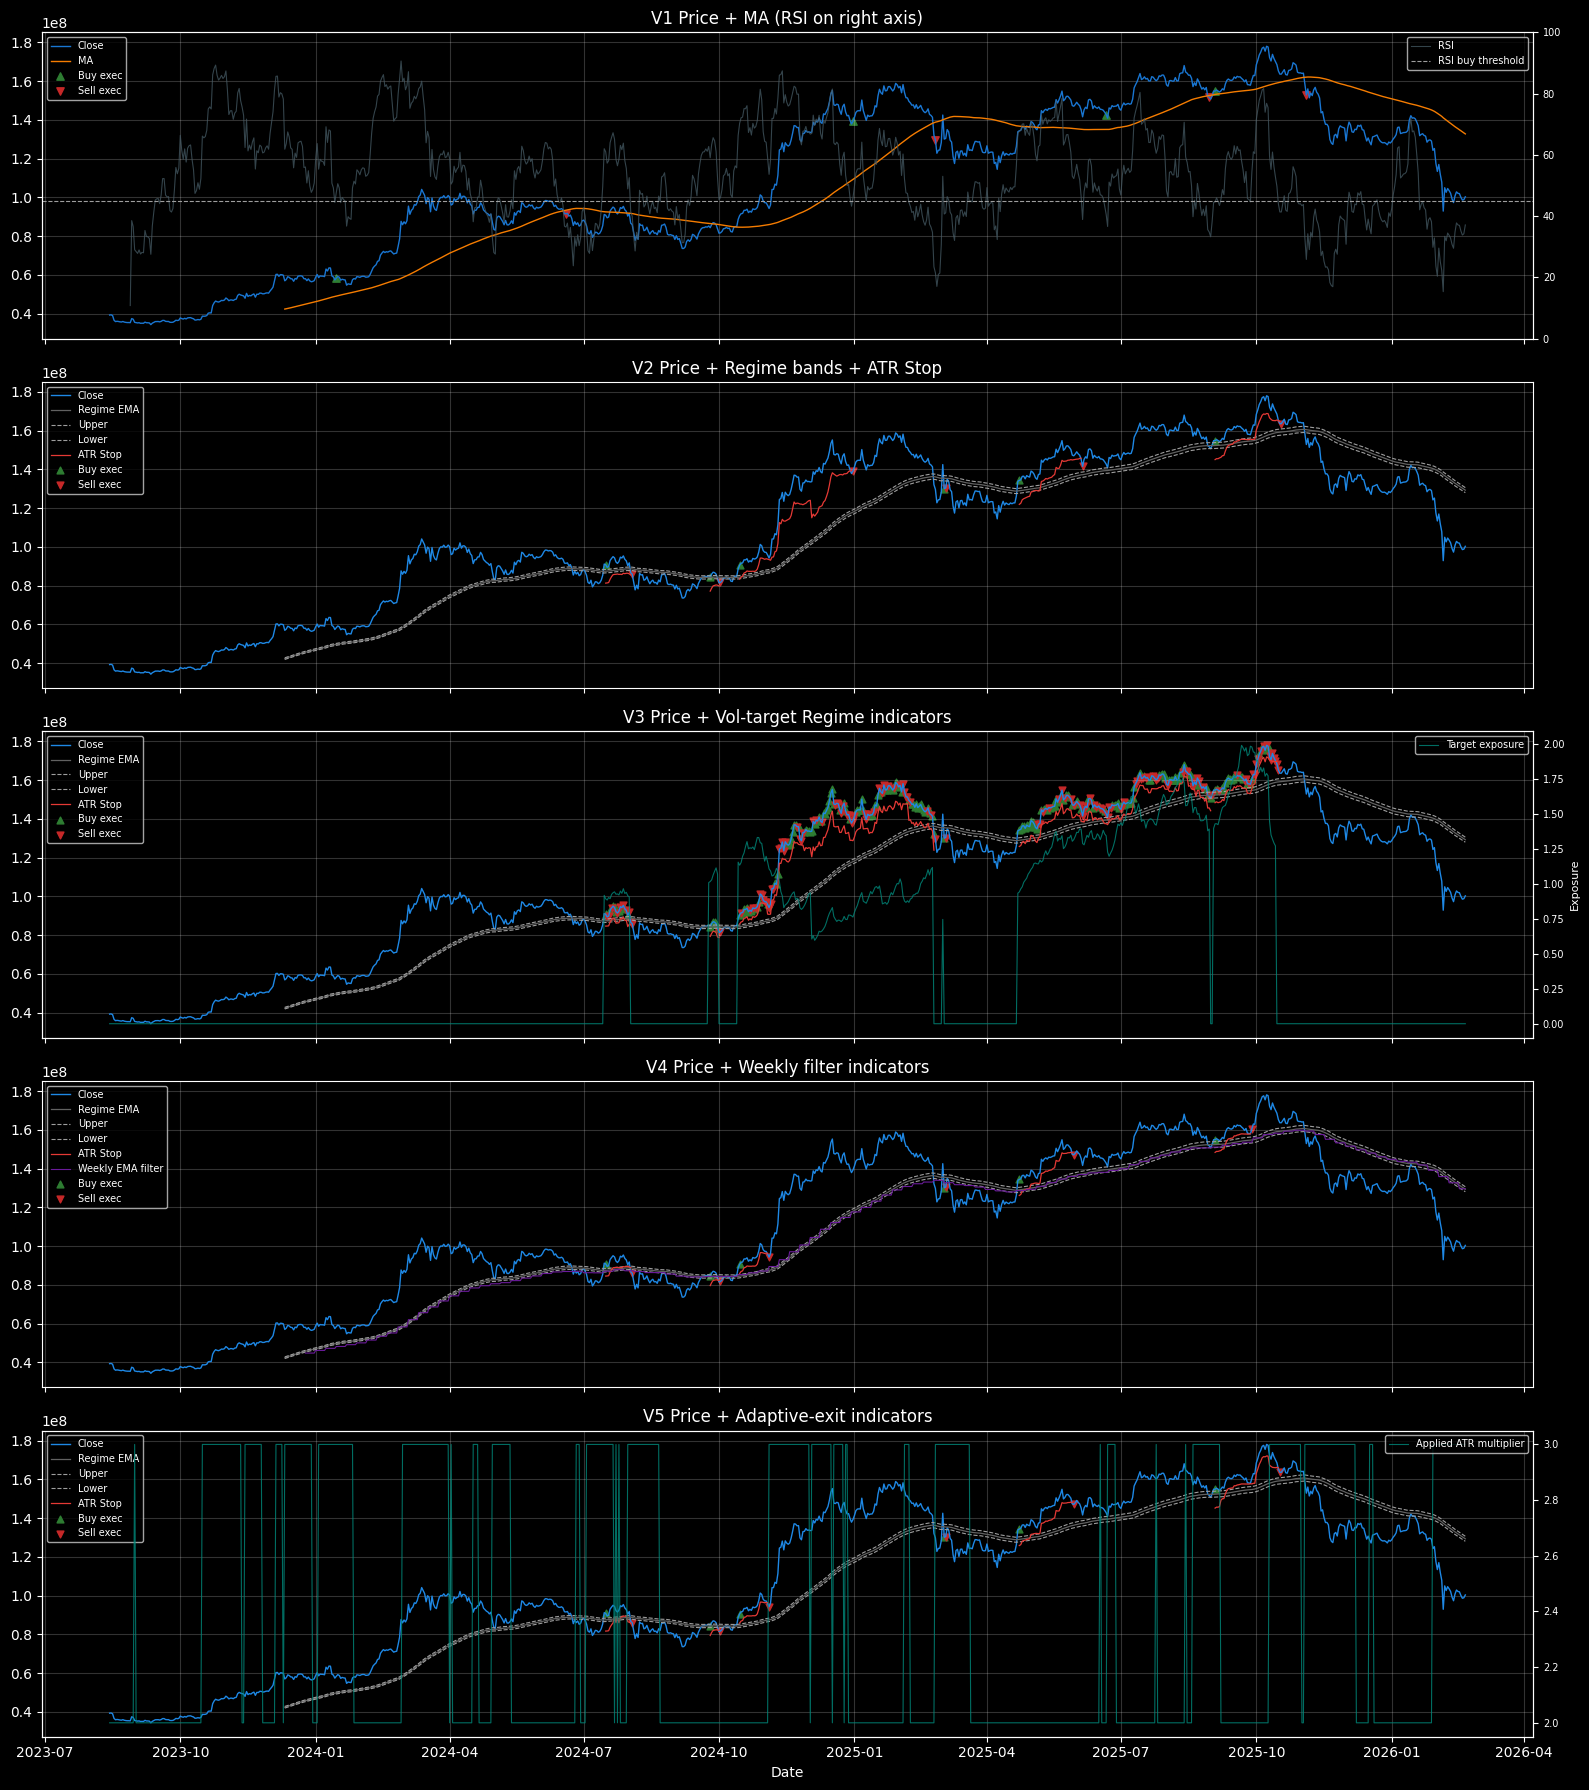

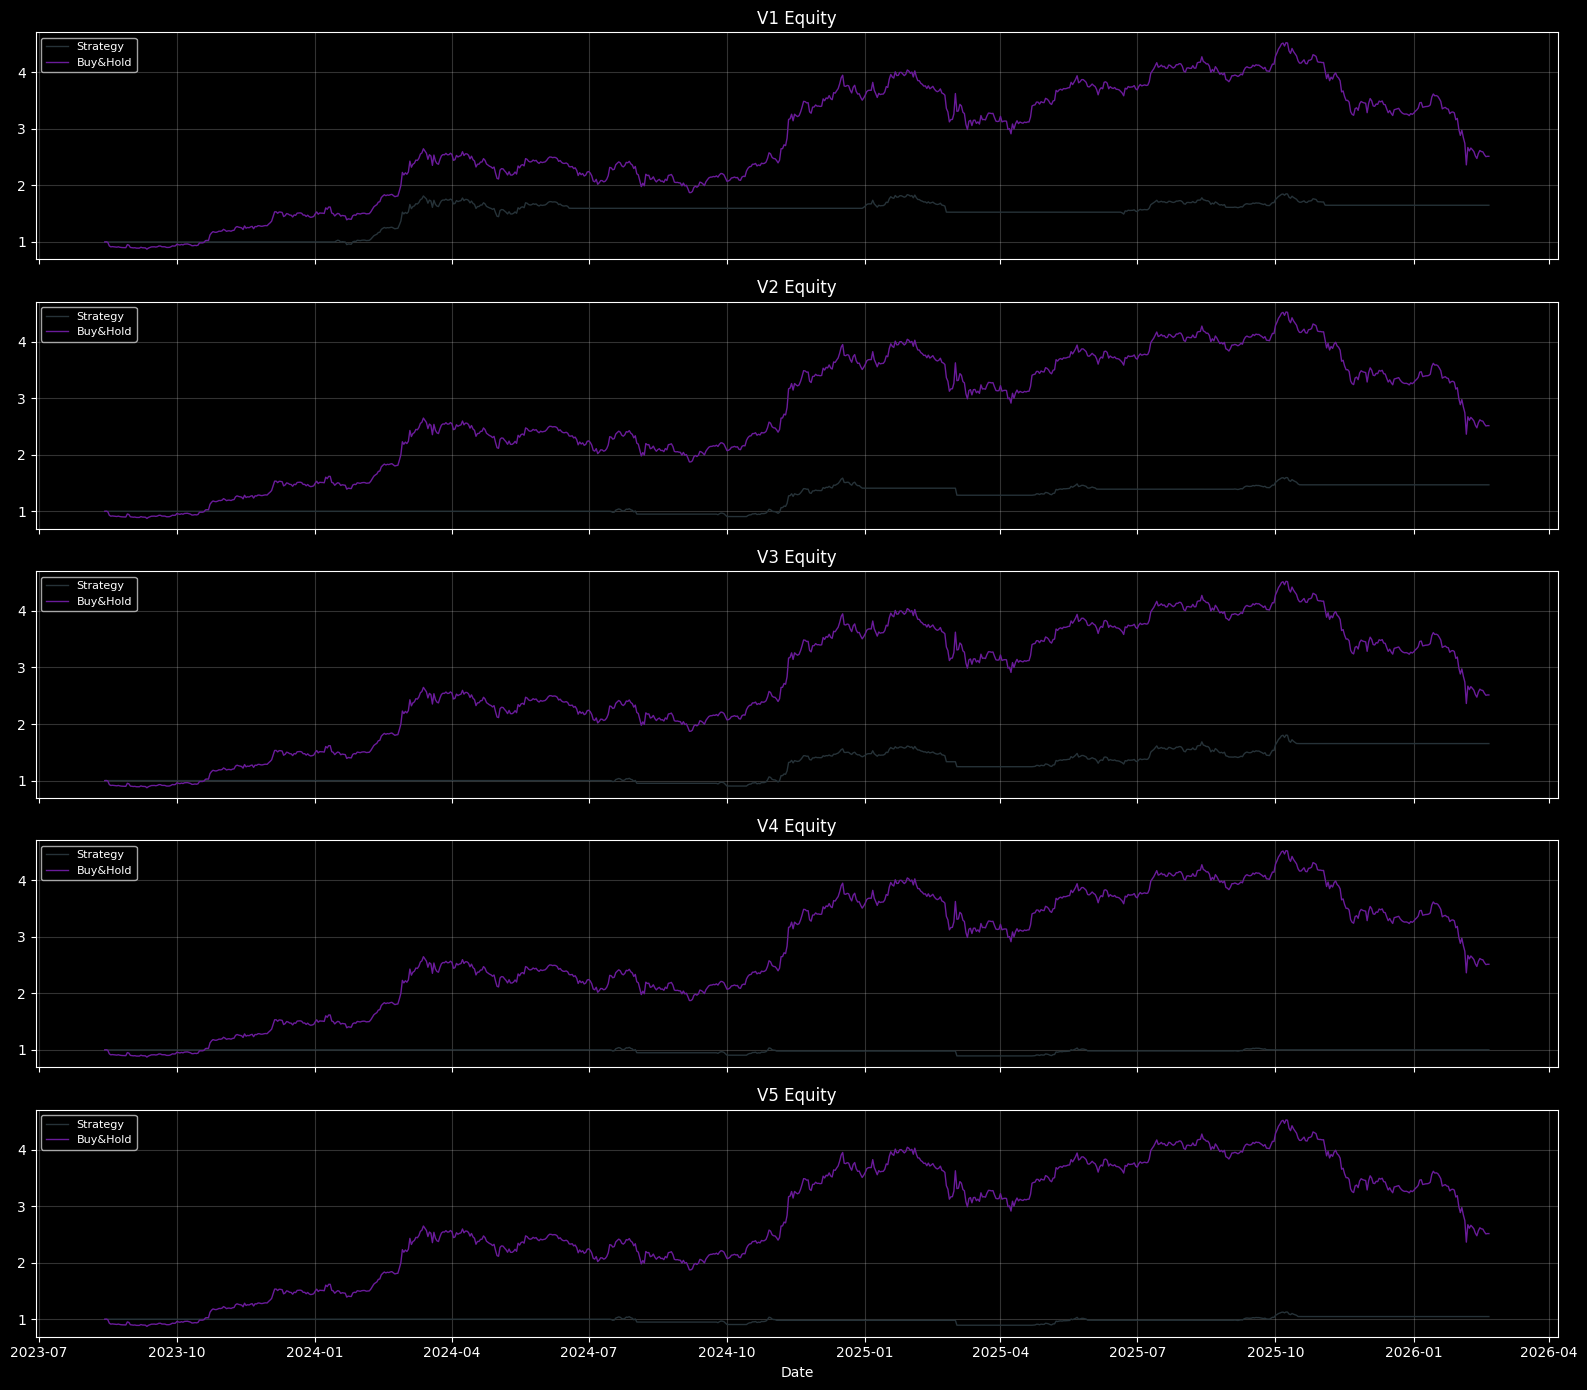

In [176]:
def trade_points(rows):
    buy_idx, sell_idx = [], []
    for i in range(1, len(rows)):
        if rows[i].pos_open > rows[i - 1].pos_open:
            buy_idx.append(i)
        if rows[i].pos_open < rows[i - 1].pos_open:
            sell_idx.append(i)
    return buy_idx, sell_idx

# ---------- Price + Indicators for v1..v5 ----------
fig_price, axp = plt.subplots(5, 1, figsize=(16, 18), sharex=True)

# v1
v1_t = [r.timestamp for r in res_v1_test.rows]
v1_c = [r.close for r in res_v1_test.rows]
v1_ma = [r.ma for r in res_v1_test.rows]
v1_rsi = [r.rsi for r in res_v1_test.rows]
v1_buy, v1_sell = trade_points(res_v1_test.rows)
axp[0].plot(v1_t, v1_c, label='Close', linewidth=1.0, color='#1976d2')
axp[0].plot(v1_t, v1_ma, label='MA', linewidth=1.0, color='#f57c00')
axp[0].scatter([v1_t[i] for i in v1_buy], [v1_c[i] for i in v1_buy], marker='^', s=28, color='#2e7d32', label='Buy exec')
axp[0].scatter([v1_t[i] for i in v1_sell], [v1_c[i] for i in v1_sell], marker='v', s=28, color='#c62828', label='Sell exec')
axp[0].set_title('V1 Price + MA (RSI on right axis)')
axp[0].grid(alpha=0.2)
v1r = axp[0].twinx()
v1r.plot(v1_t, v1_rsi, label='RSI', linewidth=0.8, color='#455a64', alpha=0.75)
v1r.axhline(best_v1.params.rsi_buy, color='#9e9e9e', linestyle='--', linewidth=0.8, label='RSI buy threshold')
v1r.set_ylim(0, 100)
v1r.tick_params(axis='y', labelsize=7)
axp[0].legend(loc='upper left', fontsize=7)
v1r.legend(loc='upper right', fontsize=7)

# v2
v2_t = [r.timestamp for r in res_v2_test.rows]
v2_c = [r.close for r in res_v2_test.rows]
v2_a = [r.regime_anchor for r in res_v2_test.rows]
v2_u = [r.regime_upper for r in res_v2_test.rows]
v2_l = [r.regime_lower for r in res_v2_test.rows]
v2_s = [r.atr_trail_stop for r in res_v2_test.rows]
v2_buy, v2_sell = trade_points(res_v2_test.rows)
axp[1].plot(v2_t, v2_c, label='Close', linewidth=1.0, color='#1e88e5')
axp[1].plot(v2_t, v2_a, label='Regime EMA', linewidth=0.9, color='#616161')
axp[1].plot(v2_t, v2_u, label='Upper', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[1].plot(v2_t, v2_l, label='Lower', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[1].plot(v2_t, v2_s, label='ATR Stop', linewidth=0.9, color='#e53935')
axp[1].scatter([v2_t[i] for i in v2_buy], [v2_c[i] for i in v2_buy], marker='^', s=24, color='#2e7d32', label='Buy exec')
axp[1].scatter([v2_t[i] for i in v2_sell], [v2_c[i] for i in v2_sell], marker='v', s=24, color='#c62828', label='Sell exec')
axp[1].set_title('V2 Price + Regime bands + ATR Stop')
axp[1].grid(alpha=0.2)
axp[1].legend(loc='upper left', fontsize=7)

# v3
v3_t = [r.timestamp for r in res_v3_test.rows]
v3_c = [r.close for r in res_v3_test.rows]
v3_a = [r.regime_anchor for r in res_v3_test.rows]
v3_u = [r.regime_upper for r in res_v3_test.rows]
v3_l = [r.regime_lower for r in res_v3_test.rows]
v3_s = [r.atr_trail_stop for r in res_v3_test.rows]
v3_target = [r.target_exposure for r in res_v3_test.rows]
v3_buy, v3_sell = trade_points(res_v3_test.rows)
axp[2].plot(v3_t, v3_c, label='Close', linewidth=1.0, color='#1e88e5')
axp[2].plot(v3_t, v3_a, label='Regime EMA', linewidth=0.9, color='#616161')
axp[2].plot(v3_t, v3_u, label='Upper', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[2].plot(v3_t, v3_l, label='Lower', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[2].plot(v3_t, v3_s, label='ATR Stop', linewidth=0.9, color='#e53935')
axp[2].scatter([v3_t[i] for i in v3_buy], [v3_c[i] for i in v3_buy], marker='^', s=24, color='#2e7d32', label='Buy exec')
axp[2].scatter([v3_t[i] for i in v3_sell], [v3_c[i] for i in v3_sell], marker='v', s=24, color='#c62828', label='Sell exec')
axp[2].set_title('V3 Price + Vol-target Regime indicators')
axp[2].grid(alpha=0.2)
v3r = axp[2].twinx()
v3r.plot(v3_t, v3_target, label='Target exposure', linewidth=0.8, color='#00897b', alpha=0.8)
v3r.set_ylabel('Exposure', fontsize=8)
v3r.tick_params(axis='y', labelsize=7)
axp[2].legend(loc='upper left', fontsize=7)
v3r.legend(loc='upper right', fontsize=7)

# v4
v4_t = [r.timestamp for r in res_v4_test.rows]
v4_c = [r.close for r in res_v4_test.rows]
v4_a = [r.regime_anchor for r in res_v4_test.rows]
v4_u = [r.regime_upper for r in res_v4_test.rows]
v4_l = [r.regime_lower for r in res_v4_test.rows]
v4_s = [r.atr_trail_stop for r in res_v4_test.rows]
v4_we = [r.weekly_ema for r in res_v4_test.rows]
v4_buy, v4_sell = trade_points(res_v4_test.rows)
axp[3].plot(v4_t, v4_c, label='Close', linewidth=1.0, color='#1e88e5')
axp[3].plot(v4_t, v4_a, label='Regime EMA', linewidth=0.9, color='#616161')
axp[3].plot(v4_t, v4_u, label='Upper', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[3].plot(v4_t, v4_l, label='Lower', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[3].plot(v4_t, v4_s, label='ATR Stop', linewidth=0.9, color='#e53935')
axp[3].plot(v4_t, v4_we, label='Weekly EMA filter', linewidth=0.8, color='#6a1b9a')
axp[3].scatter([v4_t[i] for i in v4_buy], [v4_c[i] for i in v4_buy], marker='^', s=24, color='#2e7d32', label='Buy exec')
axp[3].scatter([v4_t[i] for i in v4_sell], [v4_c[i] for i in v4_sell], marker='v', s=24, color='#c62828', label='Sell exec')
axp[3].set_title('V4 Price + Weekly filter indicators')
axp[3].grid(alpha=0.2)
axp[3].legend(loc='upper left', fontsize=7)

# v5
v5_t = [r.timestamp for r in res_v5_test.rows]
v5_c = [r.close for r in res_v5_test.rows]
v5_a = [r.regime_anchor for r in res_v5_test.rows]
v5_u = [r.regime_upper for r in res_v5_test.rows]
v5_l = [r.regime_lower for r in res_v5_test.rows]
v5_s = [r.atr_trail_stop for r in res_v5_test.rows]
v5_m = [r.atr_trail_multiplier_applied for r in res_v5_test.rows]
v5_buy, v5_sell = trade_points(res_v5_test.rows)
axp[4].plot(v5_t, v5_c, label='Close', linewidth=1.0, color='#1e88e5')
axp[4].plot(v5_t, v5_a, label='Regime EMA', linewidth=0.9, color='#616161')
axp[4].plot(v5_t, v5_u, label='Upper', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[4].plot(v5_t, v5_l, label='Lower', linewidth=0.8, linestyle='--', color='#9e9e9e')
axp[4].plot(v5_t, v5_s, label='ATR Stop', linewidth=0.9, color='#e53935')
axp[4].scatter([v5_t[i] for i in v5_buy], [v5_c[i] for i in v5_buy], marker='^', s=24, color='#2e7d32', label='Buy exec')
axp[4].scatter([v5_t[i] for i in v5_sell], [v5_c[i] for i in v5_sell], marker='v', s=24, color='#c62828', label='Sell exec')
axp[4].set_title('V5 Price + Adaptive-exit indicators')
axp[4].grid(alpha=0.2)
v5r = axp[4].twinx()
v5r.plot(v5_t, v5_m, label='Applied ATR multiplier', linewidth=0.8, color='#00897b', alpha=0.8)
v5r.tick_params(axis='y', labelsize=7)
axp[4].legend(loc='upper left', fontsize=7)
v5r.legend(loc='upper right', fontsize=7)
axp[4].set_xlabel('Date')

fig_price.tight_layout()
plt.show()

# ---------- Equity for v1..v5 ----------
fig_equity, axe = plt.subplots(5, 1, figsize=(16, 14), sharex=True)

def plot_equity(ax, rows, title):
    t = [r.timestamp for r in rows]
    ax.plot(t, [r.equity for r in rows], label='Strategy', color='#263238', linewidth=1.0)
    ax.plot(t, [r.equity_bh for r in rows], label='Buy&Hold', color='#6a1b9a', linewidth=1.0)
    ax.set_title(title)
    ax.grid(alpha=0.2)
    ax.legend(loc='upper left', fontsize=8)

plot_equity(axe[0], res_v1_test.rows, 'V1 Equity')
plot_equity(axe[1], res_v2_test.rows, 'V2 Equity')
plot_equity(axe[2], res_v3_test.rows, 'V3 Equity')
plot_equity(axe[3], res_v4_test.rows, 'V4 Equity')
plot_equity(axe[4], res_v5_test.rows, 'V5 Equity')
axe[4].set_xlabel('Date')

fig_equity.tight_layout()
plt.show()



In [177]:
out_dir = REPO_ROOT / 'outputs' / 'charts'
out_dir.mkdir(parents=True, exist_ok=True)
price_path = out_dir / 'python_backtest_playground_price_v1_v5.png'
equity_path = out_dir / 'python_backtest_playground_equity_v1_v5.png'
fig_price.savefig(price_path, dpi=140, bbox_inches='tight')
fig_equity.savefig(equity_path, dpi=140, bbox_inches='tight')
{'price': price_path, 'equity': equity_path}


{'price': WindowsPath('C:/Users/phant/IdeaProjects/evergreen/outputs/charts/python_backtest_playground_price_v1_v5.png'),
 'equity': WindowsPath('C:/Users/phant/IdeaProjects/evergreen/outputs/charts/python_backtest_playground_equity_v1_v5.png')}